# Image classification using PyTorch
* Create a virtual environment and install PyTorch in it
* Write command in terminal as:
--> python -m venv {name of venv}

* to activate
--> \{name of venv}\Scripts\activate

* inspall pytorch:
--> pip install torch

* install ipynb kernel
--> pip install ipykernel

* setup ipykernel for using jupyter notebook
--> pyhton -m ipykernel install --user --name {give any name to your kernel}

* to deactivate
--> deactivate

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [2]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # it means we want to randomly resize and images to this size i.e. 224x224
        transforms.RandomHorizontalFlip(), # horizontally flip the image
        transforms.ToTensor(), # Transforming images to Tensor, because pytorch accepts the data inthe form of tensor,,, its a mandatory step
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # colored images : r-g-b channels, Normalizing the data so that entire input is on the same scale
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # resizing the image
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
}

# what happens when we perform data sugmentation
# we are providing a variety of scenarios so that our model will learn to generalize in a good way
# hence this step of data augmentation

In [7]:
# Define data directory
data_dir = 'datasets'

# create data loaders
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}


# what are data loaders : responsible to load the data

In [9]:
import torch.utils
import torch.utils.data


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
# We are loading the train and val data into mini batch of batch_size = 4
# batch_size = 4, bnatches of 4 images are taken
# shuffle = True , while training data will keep on shuffling
# num_workers = 4, we want to parallelize the process, we want 4 different processes can work

# Below command is for checking the sizes of the train and val datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 854, 'val': 148}


In [13]:
class_names = image_datasets['train'].classes
class_names
# note than : class name is same as the folder name for respective class (key point to note)
# this is the target variable , i.e. output class labels

['daisy', 'dendelion']

## Training the model (model : ResNet-18)
* in this example, we will pick a pretrained model, which has already been trained on some dataset
* we will freeze all the layers except the output/last classification layer, 
* then we will finetune our model to detect the image as either daily or dendelion

In [16]:
# Load a pretrained model ResNet-18 model
model = models.resnet18(pretrained = True)

# freeze all layers except the final classification layer
for name, param in model.named_parameters():
    if 'fc' in name: # unfreeze the final classification layer' ,, fc -> fully connected layer
        param.requires_grad = True
        # whereever 'fc' is present, we are training those layers  
    else:
        param.requires_grad = False
        # all these layers will be freezed
    
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # for a classification problem, most commonly used loss function
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # use all parameters, SGD -> Stochastic gradient descent

# move the model to GPU, if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# Training loop
num_epochs = 10 # can increase if data set is huge
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0 # these two variables are used to store loss and correct predn inside every epoch
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device) # loading inout data on 'device' (gpu or cpu)
            labels = labels.to(device) # loading class labels

            optimizer.zero_grad() # clear the gradient from prev iteration

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs) # to make predictions and store in 'output'
                _, preds = torch.max(outputs, 1) # for showing the predictions
                loss = criterion(outputs, labels) # calculating the loss between predn and actual labels, predicted label = output, and acutal label = labels

                if phase == 'train':
                    # in CNN there are forward pass and backward pass (back propagation)
                    # firstly, in forward pass, model is trained and labels are predicted
                    # after that, in back propagation, we calculate the gradients and update the weights
                    # again in forward pass, we again train the model with updated weights 
                    loss.backward() # we are calcualting the grdient (backward pass)
                    optimizer.step() # we are updating the weights on the basis of calculated gradient in prev. step

            running_loss += loss.item() * inputs.size(0) # both these commands are storing the losses and correct predictions
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase] # For viewing epoch wise loss and accuracy
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete!")

train Loss: 0.5344 Acc: 0.9087
val Loss: 0.1806 Acc: 0.9392
train Loss: 0.1829 Acc: 0.9438
val Loss: 0.1243 Acc: 0.9662
train Loss: 0.1137 Acc: 0.9637
val Loss: 0.0994 Acc: 0.9662
train Loss: 0.0988 Acc: 0.9614
val Loss: 0.1712 Acc: 0.9392
train Loss: 0.1228 Acc: 0.9614
val Loss: 0.1200 Acc: 0.9527
train Loss: 0.1069 Acc: 0.9567
val Loss: 0.0773 Acc: 0.9730
train Loss: 0.0761 Acc: 0.9719
val Loss: 0.0593 Acc: 0.9865
train Loss: 0.0941 Acc: 0.9684
val Loss: 0.0513 Acc: 0.9865
train Loss: 0.0849 Acc: 0.9602
val Loss: 0.0611 Acc: 0.9730
train Loss: 0.1052 Acc: 0.9567
val Loss: 0.0444 Acc: 0.9797
Training complete!


In [18]:
# Save the model in CWD
torch.save(model.state_dict(), 'flower_classification_model.pth')

# Classification on unseen image
To use the saved model to classify unseen images, you need to load the saved model and then apply it to the new images for inference

In [19]:
import torch
from torchvision import models, transforms
from PIL import Image

# Note that we have to apply all the preprocessing on the test images as well that we applied on training images prior to model training

# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000) # resnet18 model is pre trained on data with 1000 class labels, i.e. output will be 1000 calss labels
model.load_state_dict(torch.load('flower_classification_model.pth'))
model.eval()

# create a new model with correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2) # for our case, we have only two class labels, this command is to match the desired output units

# copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[:2] # copy only first 2 output units, because we have two output labels, binary class problem
new_model.fc.bias.data = model.fc.bias.data[:2]


c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare your new image for classification. You should use the same data transformations you used during training. Here's an example of how to prepare an image for inference:

In [25]:
# Load and preprocess the unseen image
image_path = 'test_daisy.jpg'  # Replace with the path to your image
image = Image.open(image_path)

# Applying all preprocessing steps onthe test image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

Perform inference using the model:

In [26]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['daisy', 'dandelion']  # Make sure these class names match your training data
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: daisy


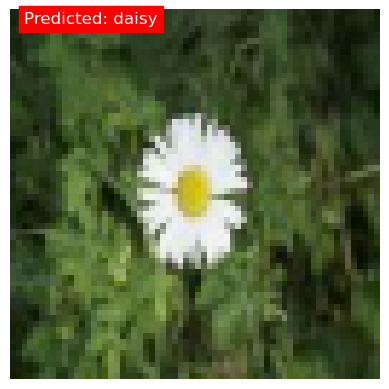

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(2, 2, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()